In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
data = np.load("i24speedcontour_64.npy")

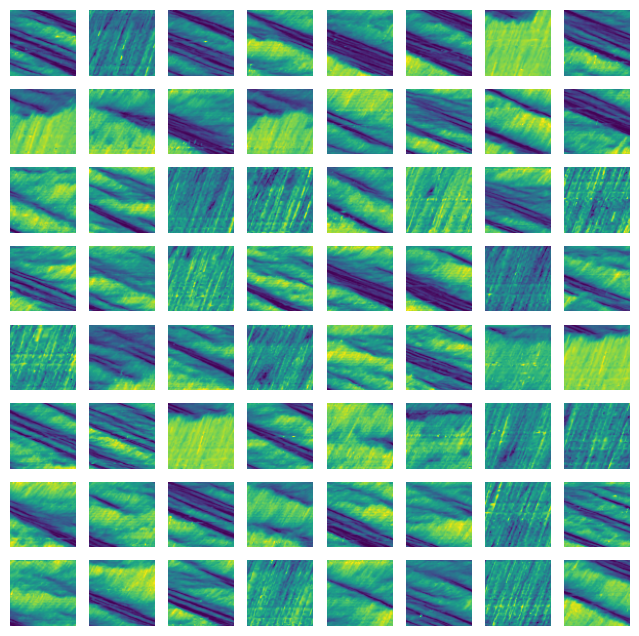

In [3]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0].T, origin="lower" )
        ax[i, j].axis("off")


In [4]:
# each data has [4,64,64] size 
# 4 : number of lanes (channel)
# 64 : spatial dimension (x)
# 64 : temporal dimension (y)
# value : speed

data = torch.tensor(data, dtype=torch.float32)
data = data.permute(0, 1, 3, 2)

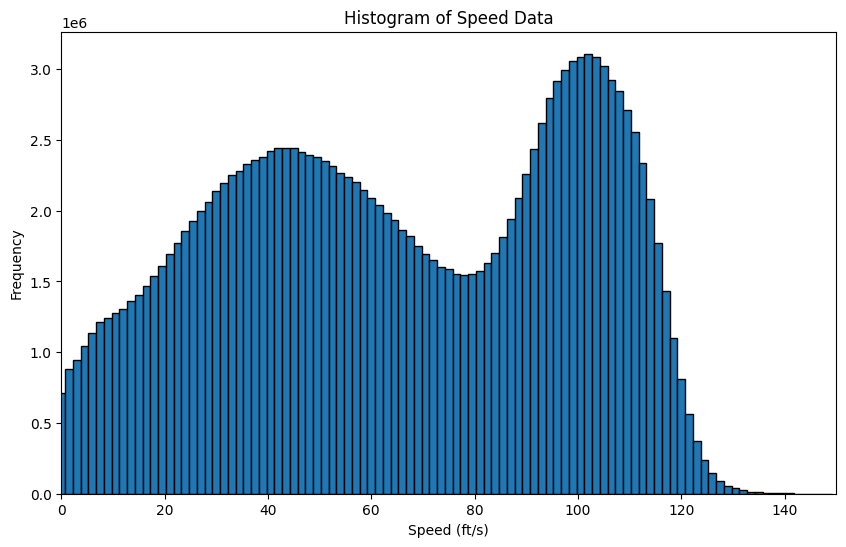

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the histogram
num_bins = 100
range_min = 0
range_max = 150
bin_edges = np.linspace(range_min, range_max, num_bins + 1)

# Initialize an array to accumulate the histogram counts
hist_counts = np.zeros(num_bins)

# Process the array in chunks
chunk_size = 100  # Adjust chunk size based on your memory constraints
num_chunks = data.shape[0] // chunk_size

for i in range(num_chunks):
    chunk = data[i * chunk_size: (i + 1) * chunk_size]
    hist_counts += np.histogram(chunk, bins=bin_edges)[0]

# Process any remaining data that wasn't included in the chunks
if data.shape[0] % chunk_size != 0:
    remaining_data = data[num_chunks * chunk_size:]
    hist_counts += np.histogram(remaining_data, bins=bin_edges)[0]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_counts, width=bin_edges[1] - bin_edges[0], edgecolor='black')
plt.xlim(range_min, range_max)
plt.xlabel('Speed (ft/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Speed Data')
plt.show()

In [6]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [7]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [8]:
# Define Generative Adversarial Network (GAN) model
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 4, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(z.size(0), 128, 8, 8)
        z = F.relu(self.conv1(z))
        z = F.relu(self.conv2(z))
        z = self.conv3(z)
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 8 * 8, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [14]:
# Define Models
model_G = Generator(latent_dim=128)
model_D = Discriminator()

# Define optimizers
opt_G = optim.Adam(model_G.parameters(), lr=1e-3)
opt_D = optim.Adam(model_D.parameters(), lr=1e-3)

In [15]:
num_epochs = 100
latent_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_G.to(device)
model_D.to(device)

train_D_loop = 1
train_G_loop = 2

for epoch in range(num_epochs):
    model_G.train()
    model_D.train()

    for real_data in (pbar := tqdm(train_loader)):
        train_loss_G = 0
        train_loss_D = 0

        real_data = real_data.to(device)

        # Train Discriminator
        for _ in range(train_D_loop):
            opt_D.zero_grad()
            z = torch.randn(real_data.size(0), latent_dim, device=device)
            fake_data = model_G(z)
            disc_real = model_D(real_data)
            disc_fake = model_D(fake_data.detach())
            loss_D = F.binary_cross_entropy_with_logits(disc_real, torch.ones_like(disc_real)) + \
                    F.binary_cross_entropy_with_logits(disc_fake, torch.zeros_like(disc_fake))
            loss_D.backward()
            opt_D.step()
            train_loss_D += loss_D.item()

        # Train Generator
        for _ in range(train_G_loop):
            opt_G.zero_grad()
            z = torch.randn(real_data.size(0), latent_dim, device=device)  # Generate new latent vectors
            fake_data = model_G(z)
            disc_fake = model_D(fake_data)
            loss_G = F.binary_cross_entropy_with_logits(disc_fake, torch.ones_like(disc_fake))
            loss_G.backward()
            opt_G.step()
            train_loss_G += loss_G.item()

        pbar.set_description(f'Epoch {epoch}, Loss G {train_loss_G / (train_G_loop):.5f}, Loss D {train_loss_D / (train_D_loop):.5f}')


Epoch 99, Loss G 0.69315, Loss D 1.38629: 100%|██████████| 125/125 [00:01<00:00, 86.42it/s]


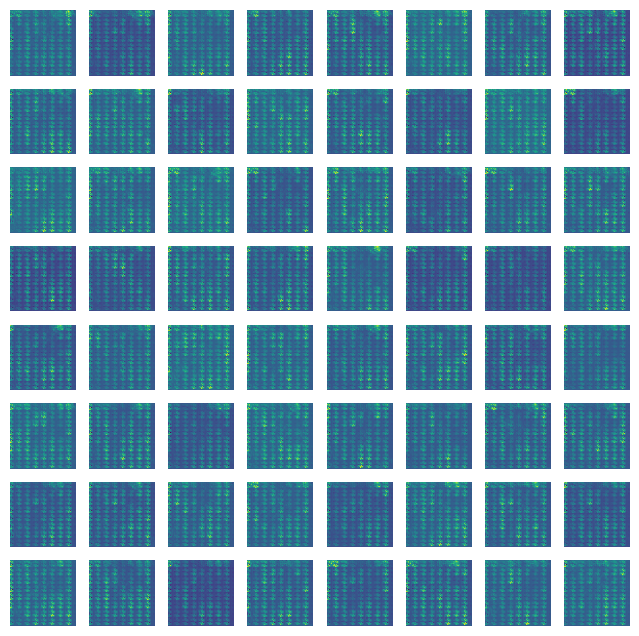

In [16]:
# sample from the latent space
model_G.eval()
z = torch.randn(64, latent_dim, device=device)
fake_data = model_G(z)
fake_data = fake_data.cpu().detach().numpy()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(fake_data[i * 8 + j][0].T, origin="lower")
        ax[i, j].axis("off")